## Overview of the project##

In this project, I would apply machine learning algorithms to predict the final price of each residential home in Ames, Iowa, using 79 explanatory variables describing most aspects of these homes. The end-user of this project could be someone who plans to buy a house in Ames or real estate agents. 
A minimum viable product (MVP) out of this project could be a Jupyter notebook that users can use to predict the sale price of houses in Ames after entering the required information.
This project will be based on supervised machine learning (ML) algorithms. I will build an ensemble ML model using the existing data (i.e., the known sale price of Ames houses with different aspects) and use this model to predict the sale price of a specific house after users enter the required information.
The dataset was originally prepared by Dean De Cock and was slightly revised by Kaggle https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data
As an MVP, the GUI of this product might be just a Jupyter notebook. But if possible, I might make it more user-friendly.


**References**

I used reproducible functions msv1 from Ami to analyze and visulize missing data. 
https://www.kaggle.com/amiiiney/price-prediction-regularization-stacking

I refered to the following link to do feature engineering, encluding how to better deal with missing data.
https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard

In [1]:
# Import core libraries.
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, LassoCV, ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder
from scipy import stats
from scipy.stats import skew
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 1000)

In [2]:
pd.show_versions()


INSTALLED VERSIONS
------------------
commit           : None
python           : 3.6.4.final.0
python-bits      : 64
OS               : Windows
OS-release       : 10
machine          : AMD64
processor        : Intel64 Family 6 Model 78 Stepping 3, GenuineIntel
byteorder        : little
LC_ALL           : None
LANG             : None
LOCALE           : None.None

pandas           : 1.0.5
numpy            : 1.18.5
pytz             : 2017.3
dateutil         : 2.6.1
pip              : 20.1.1
setuptools       : 38.4.0
Cython           : 0.27.3
pytest           : 3.3.2
hypothesis       : None
sphinx           : 1.6.6
blosc            : None
feather          : None
xlsxwriter       : 1.0.2
lxml.etree       : 4.1.1
html5lib         : 1.0.1
pymysql          : None
psycopg2         : None
jinja2           : 2.10
IPython          : 6.2.1
pandas_datareader: None
bs4              : 4.6.0
bottleneck       : 1.2.1
fastparquet      : None
gcsfs            : None
lxml.etree       : 4.1.1
matplotlib   

In [3]:
# Read the train and test datasets

df_train = pd.read_csv('ames_train.csv')
df_test = pd.read_csv('ames_test.csv')

In [4]:
#display the first five rows of the train dataset.
df_train.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
# Combine train and test datasets
ntrain = df_train.shape[0] # get the number of the observations
ntest = df_test.shape[0] # get the number of the observations
df_train_ID = df_train['Id']
df_test_ID = df_test['Id']
# Drop the target variable 'SalePrice' so I can combine df_train and df_test
target = df_train.SalePrice.values
train_test=pd.concat((df_train,df_test)).reset_index(drop = True)
train_test.drop(['SalePrice'], axis=1, inplace=True)
train_test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [6]:
#check the data size
print("\nThe train data size is : {} ".format(df_train.shape)) 
print("The test data size is : {} ".format(df_test.shape))
print("The combined data size is : {} ".format(train_test.shape))


The train data size is : (1460, 81) 
The test data size is : (1459, 80) 
The combined data size is : (2919, 80) 


In [7]:
#check all the predictors
train_test.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [8]:
# Check descriptive statistics summary on the target variable
df_train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


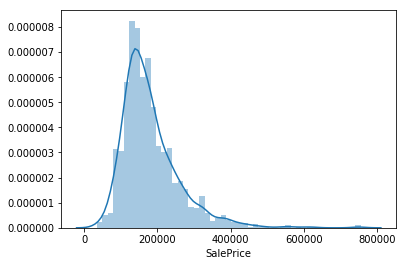

In [9]:
# Run histogram and check the distribution of the target variable
sns.distplot(df_train['SalePrice'])

Note: apparently, SalePrice is not in a normal distribution, so I'm considering doing a log transformation.
Also, I need to deal with the outliers (the expensive houses).

In [10]:
# Check skewness and kurtosis
print("Skewness: %f" % df_train['SalePrice'].skew())
print("Kurtosis: %f" % df_train['SalePrice'].kurt())

Skewness: 1.882876
Kurtosis: 6.536282


I did some research and made a few educated guesses. I will check the relationships between a few potentially important variables and the target variable.

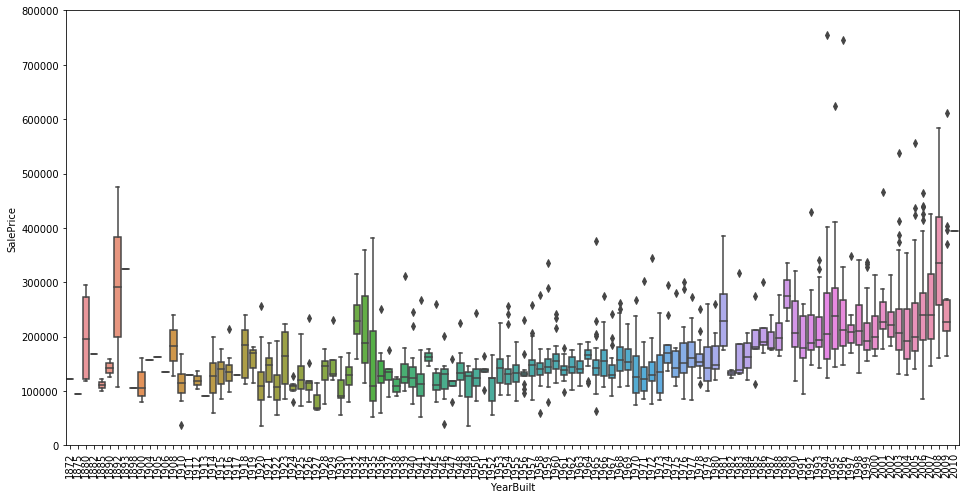

In [11]:
# Age of the house vs. SalePrice
var = 'YearBuilt'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);
plt.xticks(rotation=90);

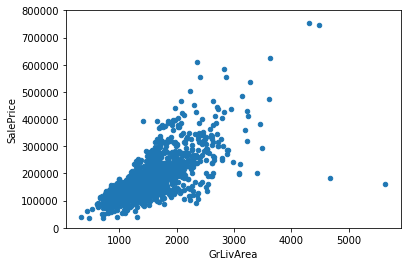

In [12]:
# size vs. saleprice
data = pd.concat([df_train['SalePrice'], df_train['GrLivArea']], axis=1)
data.plot.scatter(x='GrLivArea', y='SalePrice', ylim=(0,800000));

I will stop testing other variables for now because I will run feature importance analysis to select potentially important predicting variables.

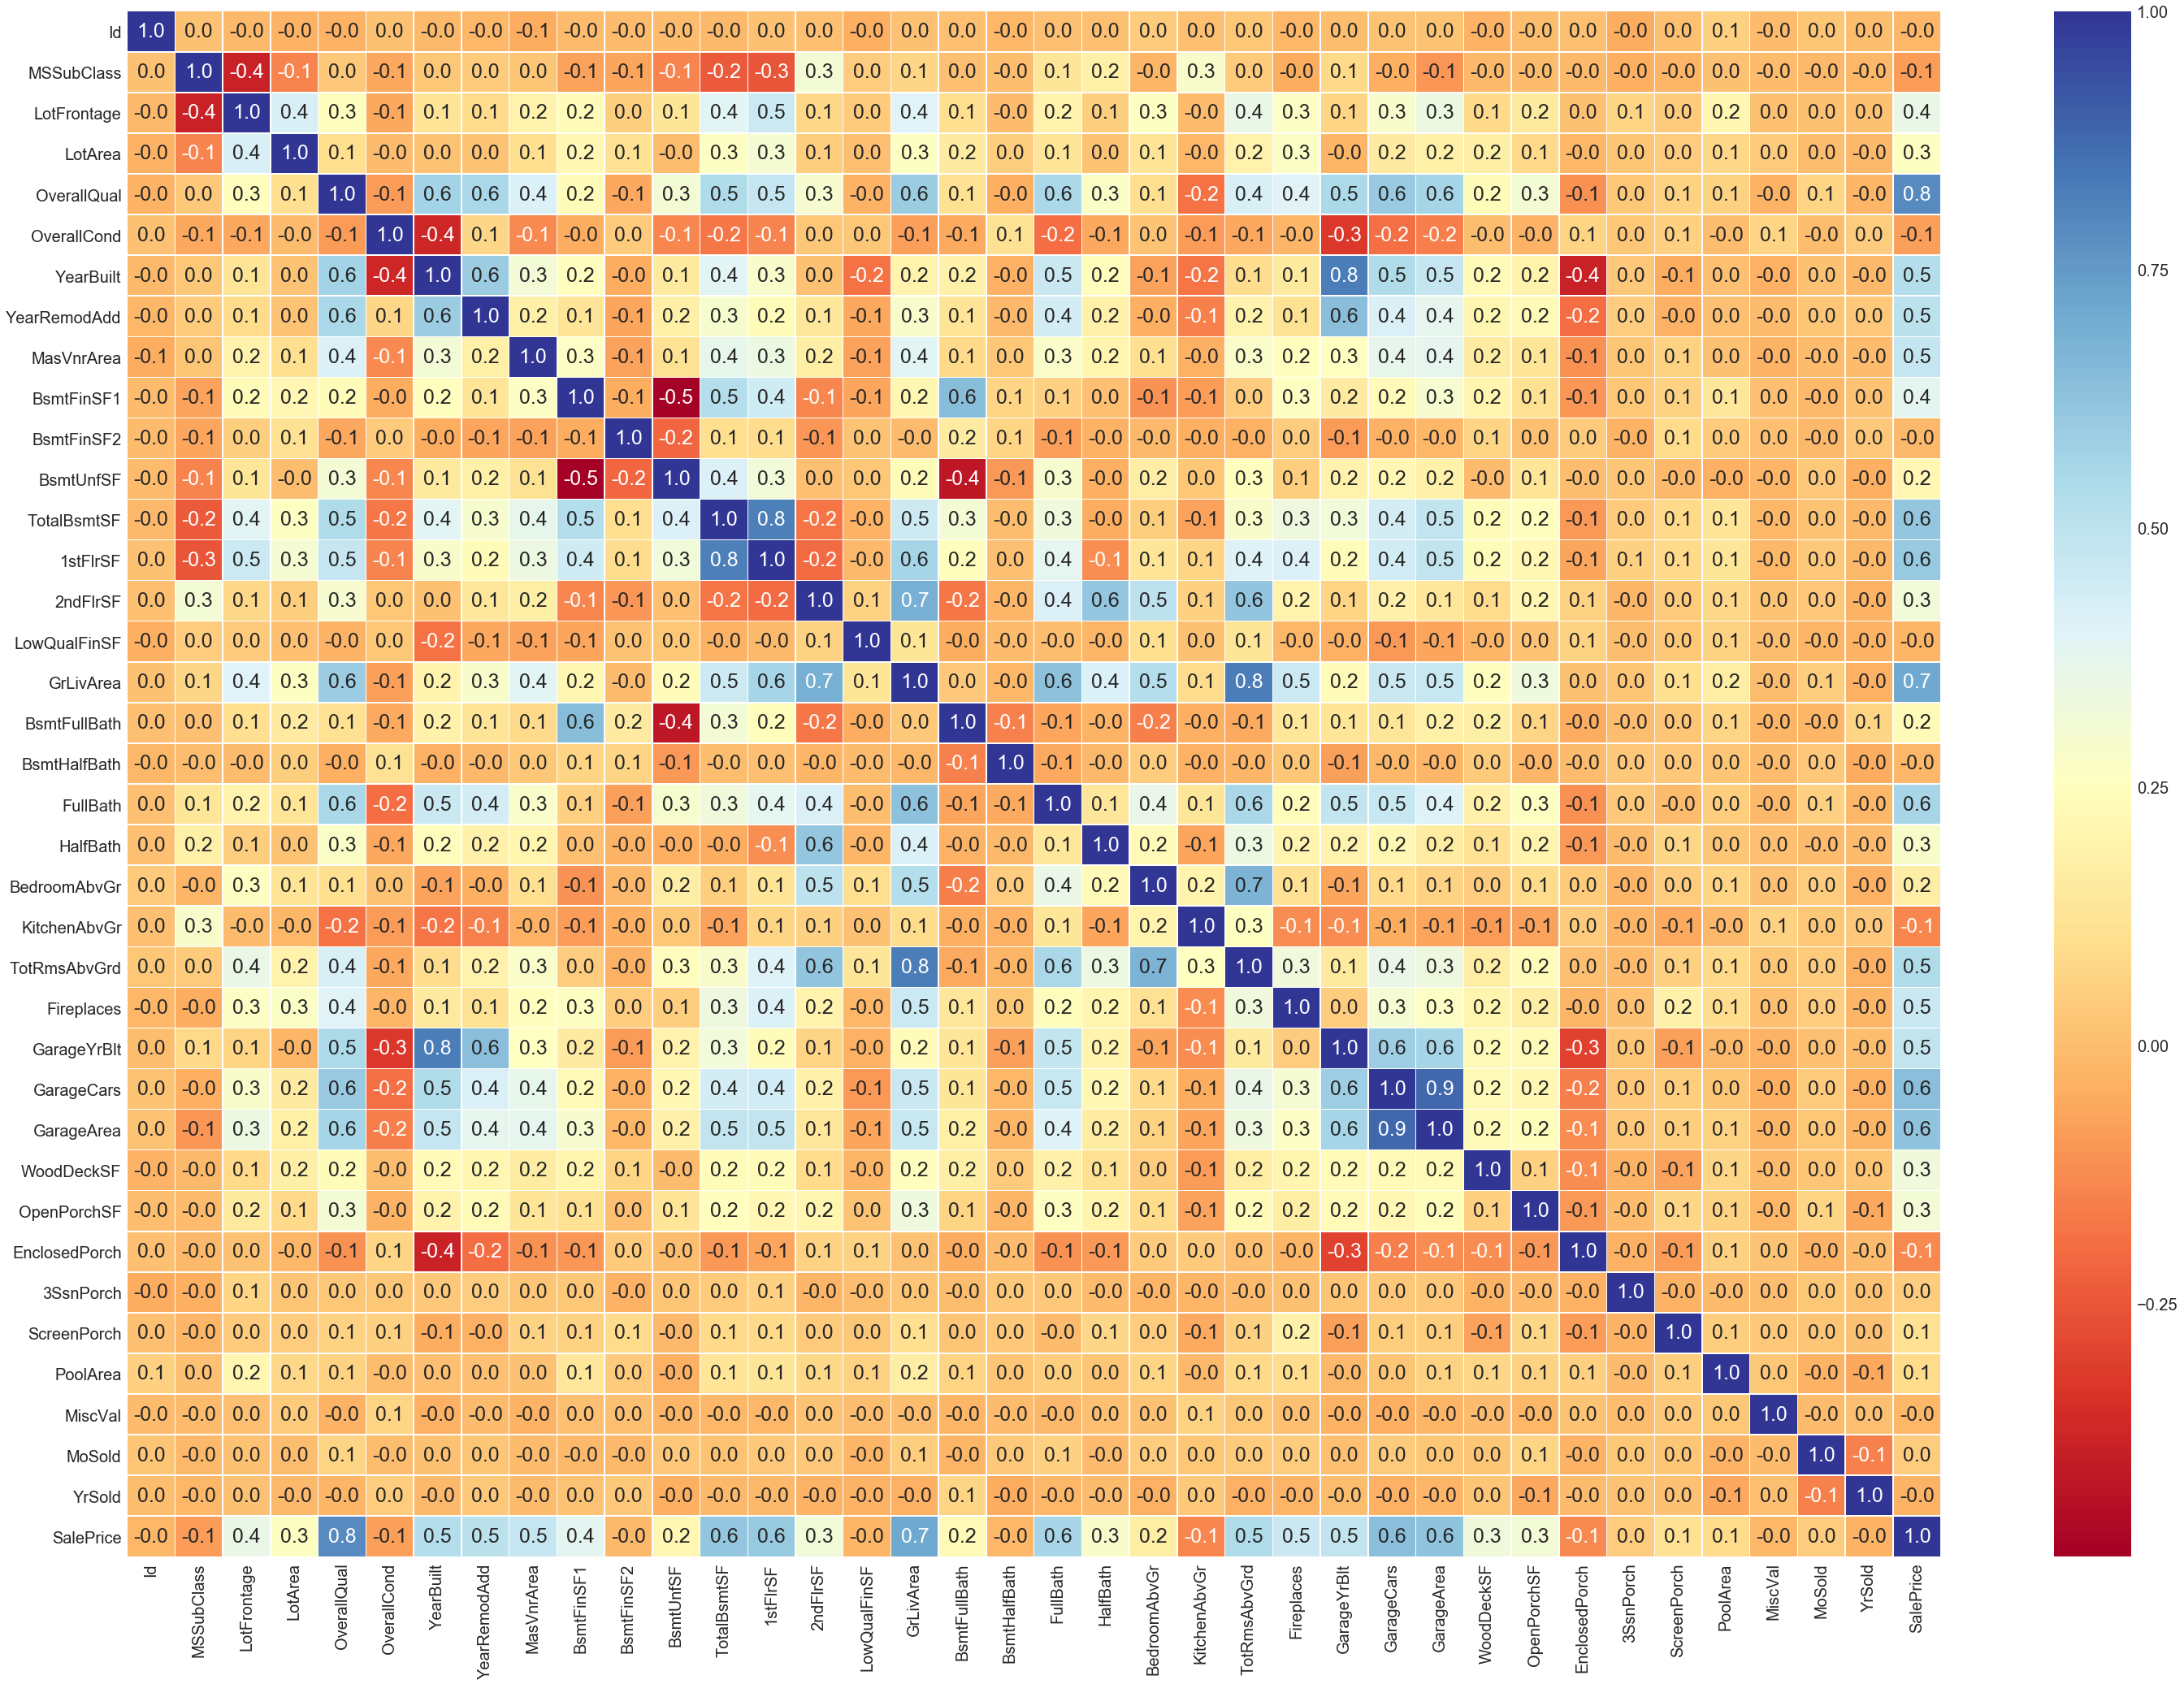

In [13]:
# run correlation matrix (major changes since last time, adding correlation coefficients)
corrmatrix = df_train.corr()
sns.set(font_scale=2)
plt.figure(figsize = (50,35))
ax = sns.heatmap(corrmatrix, annot=True,annot_kws={"size": 25},fmt='.1f',cmap='RdYlBu', linewidths=.5)

In [14]:
# Find out variables closely correlated with SalePrice
corr_dict=corrmatrix['SalePrice'].sort_values(ascending=False).to_dict()
important_columns=[]
for key,value in corr_dict.items():
    if ((value>0.1) & (value<1)) | (value<=-0.1):
        important_columns.append(key)
print(important_columns)

['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'MasVnrArea', 'Fireplaces', 'BsmtFinSF1', 'LotFrontage', 'WoodDeckSF', '2ndFlrSF', 'OpenPorchSF', 'HalfBath', 'LotArea', 'BsmtFullBath', 'BsmtUnfSF', 'BedroomAbvGr', 'ScreenPorch', 'EnclosedPorch', 'KitchenAbvGr']


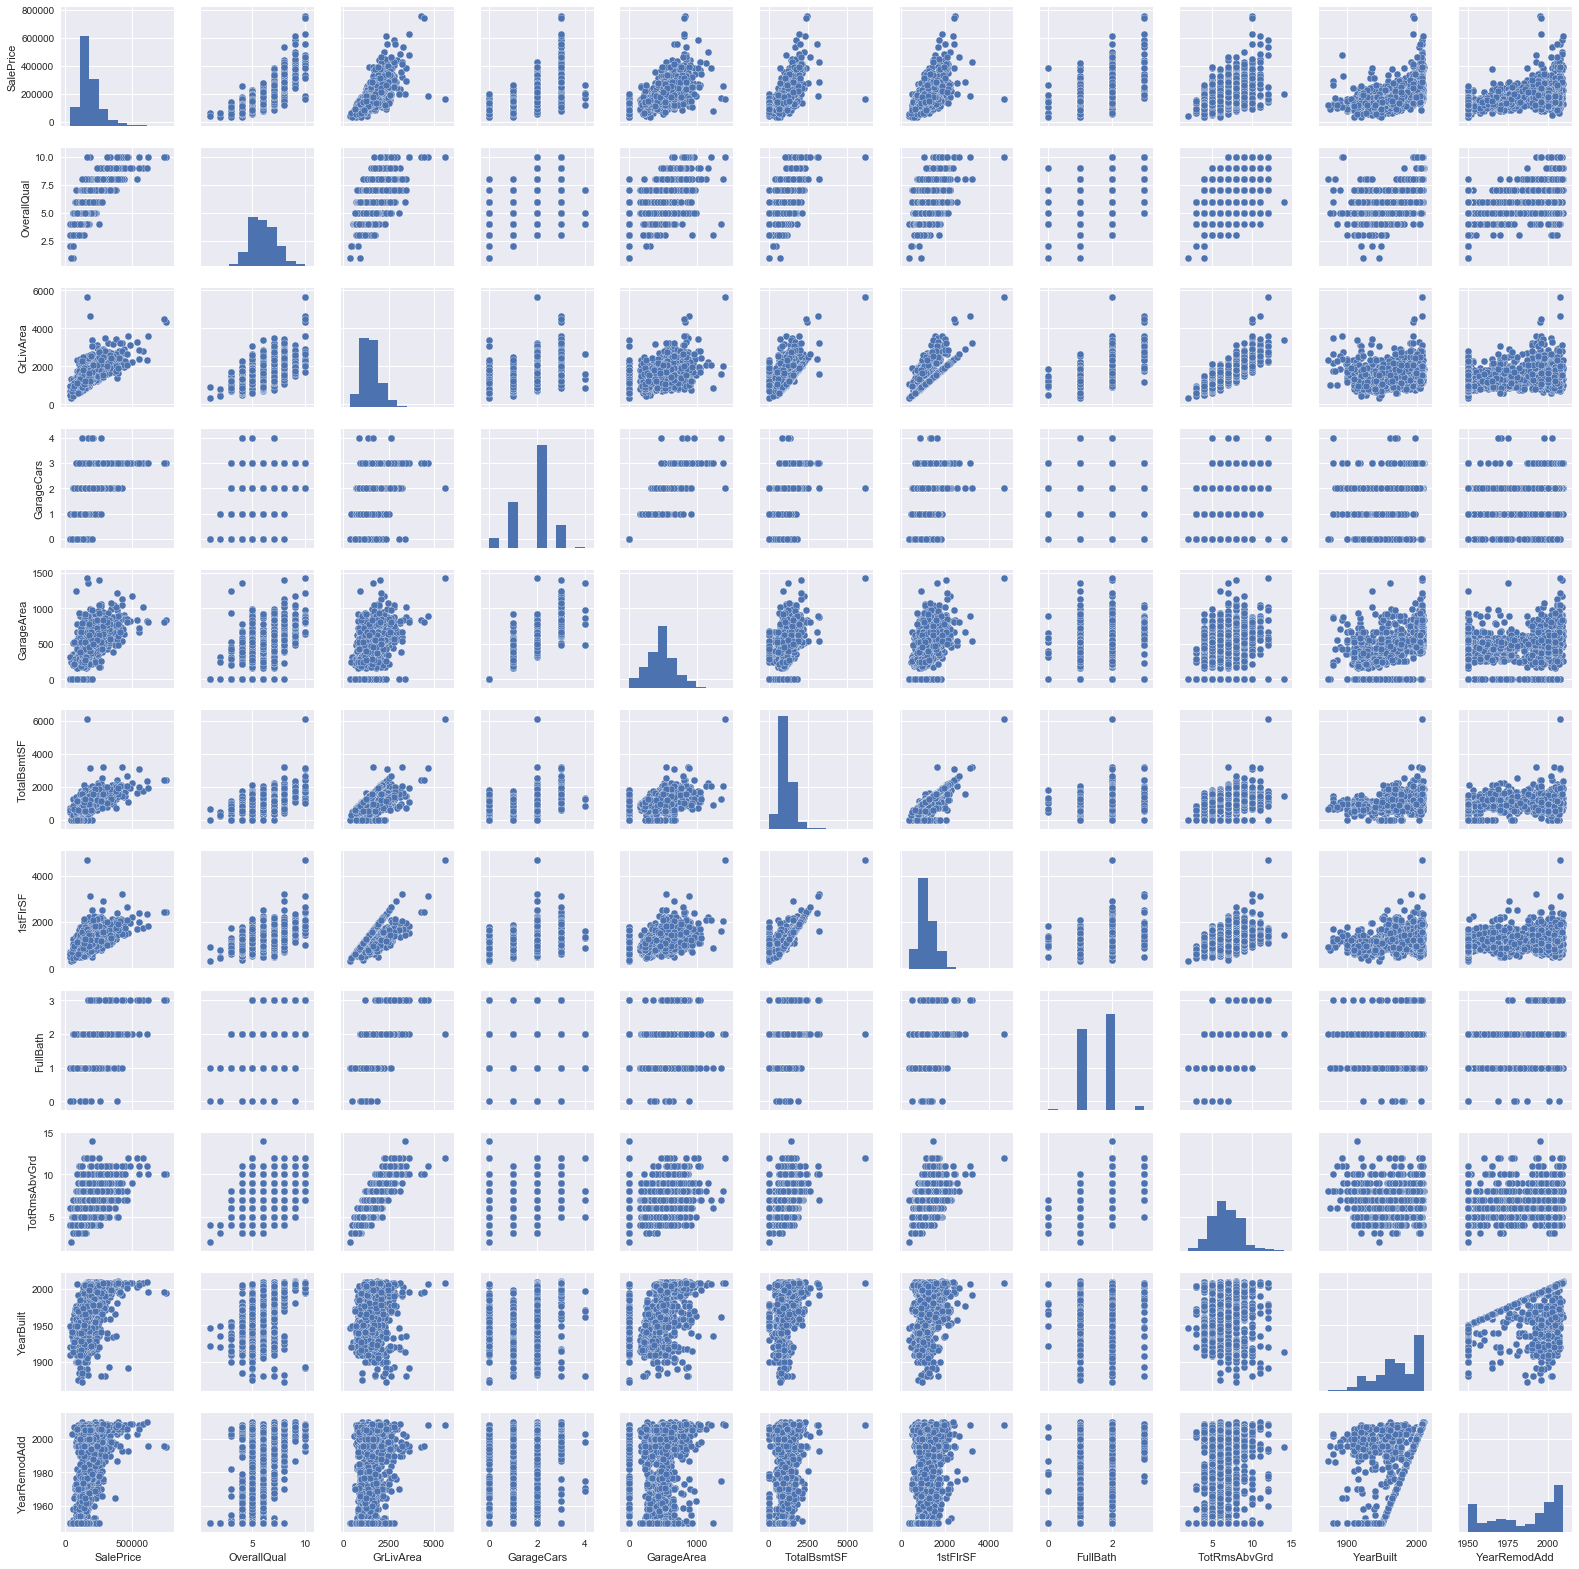

In [15]:
# Select a few potential important factors (top 10 high correaltion with SalePrice) and run the scatterplot
sns.set()
cols = ['SalePrice','OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt', 'YearRemodAdd']
sns.pairplot(df_train[cols], size = 2)
plt.show();

From the scatter plot, I can see that there are outliers for some variables. I need to figure out whether I need to do something about these outliers.

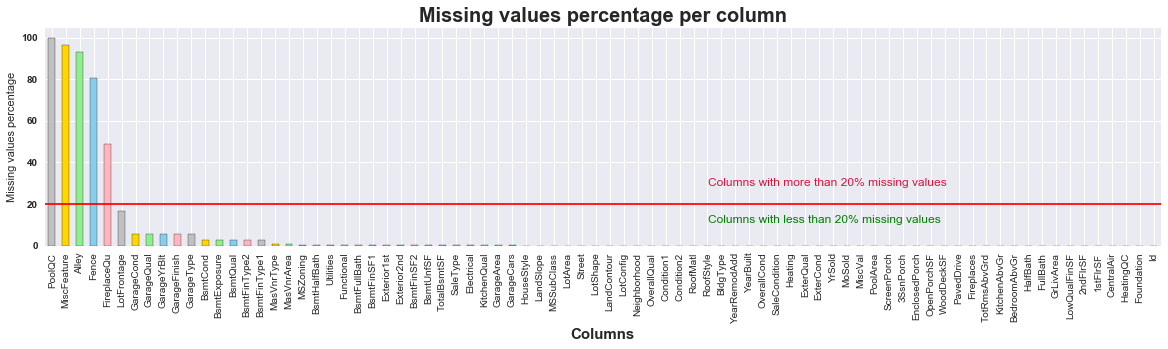

In [16]:
# analyzing missing data, the msv1 function is written by Ami
def msv1(data, thresh=20, color='black', edgecolor='black', width=20, height=4):
    """
    SOURCE: https://www.kaggle.com/amiiiney/price-prediction-regularization-stacking
    """
    
    plt.figure(figsize=(width,height))
    percentage=(data.isnull().mean())*100
    percentage.sort_values(ascending=False).plot.bar(color=color, edgecolor=edgecolor)
    plt.axhline(y=thresh, color='r', linestyle='-')
    plt.title('Missing values percentage per column', fontsize=20, weight='bold' )
    plt.text(len(data.isnull().sum()/len(data))/1.7, thresh+12.5, 'Columns with more than %s%s missing values' %(thresh, '%'), fontsize=12, color='crimson',
         ha='left' ,va='top')
    plt.text(len(data.isnull().sum()/len(data))/1.7, thresh - 5, 'Columns with less than %s%s missing values' %(thresh, '%'), fontsize=12, color='green',
         ha='left' ,va='top')
    plt.xlabel('Columns', size=15, weight='bold')
    plt.ylabel('Missing values percentage')
    plt.yticks(weight ='bold')
    
    return plt.show()

msv1(train_test, 20, color=('silver', 'gold', 'lightgreen', 'skyblue', 'lightpink'))

### Imputing missing data in the combined dataset

In [17]:
# For variable PoolQC, MiscFeature, Alley, Fench, FireplaceQu, "NA" means no such thing according to the data description.
for col in ('PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu'):
    train_test[col] = train_test[col].fillna('None')
# Replacing the missing value for "LotFrontage" with the average of that in the neighborhood
train_test["LotFrontage"] = train_test.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.mean()))
# Replacing missing data with None for variables below
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType', 'MSSubClass'):
    train_test[col] = train_test[col].fillna('None')
# Replacing missing data with 0 
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'MasVnrArea'):
    train_test[col] = train_test[col].fillna(0)
# Remove Utilities
train_test = train_test.drop(['Utilities'], axis=1)
# Replace the missing value for the variables below with the most frequent vlues in that col
train_test["Functional"] = train_test["Functional"].fillna("Typ")
# For the categorical variables below, replace the missing data with the most commonly appeared category in the col
for col in ('MSZoning', 'Electrical', 'KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType'):
    train_test[col] = train_test[col].fillna(train_test[col].mode()[0])

In [18]:
# Check again to see if there are still missing values
train_test_na = (train_test.isnull().sum() / len(train_test)) * 100
train_test_na = train_test_na.drop(train_test_na[train_test_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :train_test_na})
missing_data.head(20)
# the output shows no missing values for any variables

,Missing Ratio


In [19]:
#MSSubClass=The building class
train_test['MSSubClass'] = train_test['MSSubClass'].apply(str)
#Changing OverallCond into a categorical variable
train_test['OverallCond'] = train_test['OverallCond'].astype(str)
#Year and month sold are transformed into categorical features.
train_test['YrSold'] = train_test['YrSold'].astype(str)
train_test['MoSold'] = train_test['MoSold'].astype(str)

In [20]:
# process columns, apply LabelEncoder to categorical features

cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')
for col in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(train_test[col].values)) 
    train_test[col] = lbl.transform(list(train_test[col].values))
    
print('Shape of train_test: {}'.format(train_test.shape))

Shape of train_test: (2919, 79)


In [21]:
# Adding total sqfootage feature 
train_test['TotalSF'] = train_test['TotalBsmtSF'] + train_test['1stFlrSF'] + train_test['2ndFlrSF']

In [22]:
# Skewed features

numeric_feats = train_test.dtypes[train_test.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = train_test[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
MiscVal,21.947195
PoolArea,16.898328
LotArea,12.822431
LowQualFinSF,12.088761
3SsnPorch,11.376065
LandSlope,4.975157
KitchenAbvGr,4.302254
BsmtFinSF2,4.146143
EnclosedPorch,4.003891
ScreenPorch,3.946694


In [23]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    train_test[feat] = boxcox1p(train_test[feat], lam)

There are 60 skewed numerical features to Box Cox transform


In [24]:
# Using one hot coding to recode categorical variables
train_test=pd.get_dummies(train_test)
print(train_test.shape)

(2919, 222)


In [25]:
# Spliting train and test datasets
df_train1 = train_test[:ntrain]
df_test1 = train_test[ntrain:]

I've idetified some outliers (e.g., super expensive sale price), although some of them might not be outliers.
Anyway, I will deal with them later.

In [26]:
# For now, I will do a log transformation on the target variable: SalePrice
df_train["SalePrice"] = np.log1p(df_train["SalePrice"])

In [27]:
df_train["SalePrice"].to_csv('label.csv', index = False)

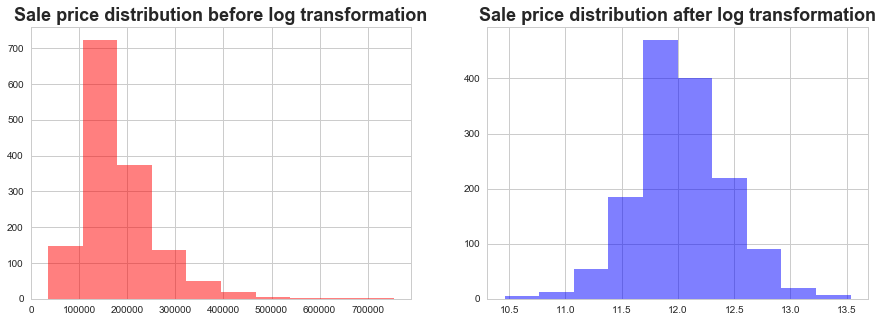

In [28]:
# Using seaborn to visulize the Sale Price before and after the log transformation
plt.style.use('seaborn')
sns.set_style('whitegrid')
fig = plt.figure(figsize=(15,5))
#1 rows 2 cols
#first row, first col
ax1 = plt.subplot2grid((1,2),(0,0))
plt.hist(target, bins=10, color='red',alpha=0.5) # target is the df_train['SalePrice] before transformation
plt.title('Sale price distribution before log transformation',weight='bold', fontsize=18)
#first row sec col
ax1 = plt.subplot2grid((1,2),(0,1))
plt.hist(df_train.SalePrice, bins=10, color='blue',alpha=0.5)
plt.title('Sale price distribution after log transformation',weight='bold', fontsize=18)
plt.show()

### Start to work on the ml part of the project. For now I just simply try a few simple algorithms such as regression. I will try more advanced one later.

In [29]:
# Following the ML project convention, I will use X and y to represent the feture set and the target set.

# y = df_train2['SalePrice']
# X = df_train2.drop(['SalePrice'], axis=1)

y = df_train['SalePrice']
X = df_train1

In [30]:
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,12.247699
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,12.109016
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,12.317171
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,11.849405
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,12.429220


In [31]:
print(X.head())
print(y.head())

         Id  MSSubClass  LotFrontage    LotArea    Street     Alley  LotShape  \
0  0.730463    2.885846     5.831328  19.212182  0.730463  0.730463  1.540963   
1  1.194318    2.055642     6.221214  19.712205  0.730463  0.730463  1.540963   
2  1.540963    2.885846     5.914940  20.347241  0.730463  0.730463  0.000000   
3  1.820334    3.011340     5.684507  19.691553  0.730463  0.730463  0.000000   
4  2.055642    2.885846     6.314735  21.325160  0.730463  0.730463  0.000000   

   LandSlope  OverallQual  OverallCond  ...  SaleType_ConLw  SaleType_New  \
0        0.0     2.440268     1.820334  ...               0             0   
1        0.0     2.259674     2.440268  ...               0             0   
2        0.0     2.440268     1.820334  ...               0             0   
3        0.0     2.440268     1.820334  ...               0             0   
4        0.0     2.602594     1.820334  ...               0             0   

   SaleType_Oth  SaleType_WD  SaleCondition_Abnorm

In [32]:
# Split the df_train2 datasets into training and testing datasets. Please note this is not talking about the original train and test datasets.
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = .3, random_state=0)

In [33]:
# Simply run linear regression as a base model. I need to figure out the error reasons but will stop for now.
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = .3, random_state=0)
lr = LinearRegression()
lr.fit(X_train, y_train)
print('Training set score: {:.2f}'.format(lr.score(X_train, y_train)))
print('Test set score: {:.2f}'.format(lr.score(X_test, y_test)))

Training set score: 0.95
Test set score: 0.81


The model has a better score in training set than in test set, an indication of overfitting. I will add restrictions to the linear regression by using lasso and ridge linear regression. I might also try other algorithms to achive better prediction scores.

In [34]:
y_pred = lr.fit(X_train, y_train).predict(df_test1)
np.set_printoptions(precision=0)
print(np.expm1(y_pred))

[117467. 173141. 180270. ... 173651. 118102. 204889.]


In [35]:
lab_enc = LabelEncoder()
y_train_encoded = lab_enc.fit_transform(y_train)
y_test_encoded = lab_enc.fit_transform(y_test)

In [36]:
rf = RandomForestClassifier(n_estimators=100,random_state=0)
rf.fit(X_train, y_train_encoded)

RandomForestClassifier(random_state=0)

In [37]:
feature_scores = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

feature_scores

Id                       0.029718
TotalSF                  0.028589
1stFlrSF                 0.027844
GrLivArea                0.027770
BsmtUnfSF                0.027643
LotArea                  0.027507
GarageArea               0.027033
TotalBsmtSF              0.026793
LotFrontage              0.026365
YearBuilt                0.023886
MoSold                   0.023743
YearRemodAdd             0.023322
GarageYrBlt              0.023118
BsmtFinSF1               0.022991
OpenPorchSF              0.020398
WoodDeckSF               0.019208
TotRmsAbvGrd             0.017294
YrSold                   0.016244
MasVnrArea               0.015438
2ndFlrSF                 0.014747
OverallQual              0.013993
BsmtFinType1             0.013976
FireplaceQu              0.012715
OverallCond              0.012298
MSSubClass               0.011260
BedroomAbvGr             0.010872
BsmtExposure             0.010843
GarageFinish             0.010812
Fireplaces               0.010242
HeatingQC     

In [38]:
Xy =pd.concat((X, y)).reset_index(drop = True)

In [39]:
key_features = ['TotalSF',
'1stFlrSF',
'GrLivArea',
'BsmtUnfSF',
'LotArea',
'GarageArea',
'TotalBsmtSF',
'LotFrontage',
'YearBuilt',
'MoSold',
'YearRemodAdd',
'GarageYrBlt',
'BsmtFinSF1',
'OpenPorchSF',
'WoodDeckSF',
'TotRmsAbvGrd',
'YrSold',
'MasVnrArea',
'2ndFlrSF',
'OverallQual',
'BsmtFinType1',
'FireplaceQu',
'OverallCond']

In [40]:
ames_core = X[key_features]

In [41]:
#ames_core = ames_core.append(df_train["SalePrice"])

In [42]:
ames_core.to_csv('ames_core.csv', index = False)

In [43]:
df_train['SalePrice'].to_csv('label.csv', index = False)